<h2>Finding Ghosts</h2>
<h2>Traccar 테스트 데이터 분석 - 전송 딜레이 확인을 중심으로</h2>


<h3>1. Research Understading</h3>
<p>
    Our ultimate goal is to understand the characteristics of people's movement by category such as age, lifecycle, disability, etc.<br>
    Hence, it is imperative that we collect numerous location data from various people. So, we need to a GPS tracking system like this:<br>
</p>
<ul>
    <li>Stable enough to deal with over 100 participants at once.</li>
    <li>Catch as much data as possible</li>
    <li>Easy to install for many different people</li>    
</ul>
<p>We think <a href="https://www.traccar.org/">Traccar</a> is suitable platform for matching our needs. We also did some experiments. It worked well as we had expected but we've got some weird data. We have to inspect suspicous data and find out whether we lost our data. If so, we must change our tracking system immediately.
    </p>

<h3>2. Data Understading</h3>
<p>
    Traccar platform consists of server and client. The client is one of reasons we chose Traccar as our first platform because it has already distributed on Appstore and Google play both. So, it can be very easily deployed to participants.<br>
</p>
<p>
    Traccar client sends a lot of attributes about location, device status, and calculated values. We've not verified about calculated ones so that we don't use them.
    </p>    
Basic attributes
<ul>
    <li>Location: (latitude, longitude)</li>
    <li>Timestamps: servertime, devicetime</li>
    <li>Battery Level</li>   
</ul>
<p><a href="https://www.traccar.org/forums/topic/what-is-fixtime-field-in-position-table/">We don't use fixtime.</a>The device status could be changed without updating GPS fix because people usually stay inside.</p>

<h3>3. Looking into Data </h3>
<h5>Client Info</h5>
<p>Test starts: 20190121<br>
Traccar Server: v4.2<br>
Freq.: 60 sec.<br>
    </p>
<table>
    <thead>
        <tr>
            <th>Name</th>
            <th>Phone</th>
            <th>OS</th>
            <th>Traccar Client</th>
            <th>Network</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>DBLAB0101</td>
            <td>V20</td>
            <td>8.0.0/F800K20i</td>
            <td>5.17</td>            
            <td>LTE (LG U+) + Wifi at home and workspace only</td>
        </tr>        
        <tr>
            <td>DBLAB0102</td>
            <td>iPhone 6</td>
            <td>12.1.2/16C104</td>
            <td>5.5</td>            
            <td>Only Wi-Fi (tethered to DBLAB0101 when outside)</td>
        </tr>
        <tr>
            <td>DBLAB0103</td>
            <td>S5</td>
            <td>6.0.1/F800K20i</td>
            <td>5.17</td>            
            <td>Only Wi-Fi (tethered to DBLAB0101 when outside)</td>
        </tr>
        <tr>
            <td>DBLAB0201</td>
            <td>iPhone XS</td>
            <td>12.1.2</td>
            <td>5.5</td>            
            <td>LTE (SKT) + Wifi at home and workspace only</td>
        </tr>
        <tr>
            <td>DBLAB0301</td>
            <td>iPhone X</td>
            <td>12.1.3 beta 4</td>
            <td>5.5</td>        
            <td>LTE (SKT) + Wifi at home and workspace only</td>
        </tr>
        <tr>
            <td>HCICG01</td>
            <td>?</td>
            <td>?</td>
            <td>?</td>            
        </tr>
    </tbody>
</table>

<p>There are six participant sending their locations to us, but they are not prepared to report their daily event yet, except DBLAB0102-03.<br>
    Moreover, we need old smartphone's data first. <b>DBLAB0102, and 0103.</b> Both are released in 2014.
    </p>
    <p>
    오래된 폰에 대한 데이터를 먼저 살펴보겠습니다. (DBLAB0102, 03. 2014년 출시 장비. 5년 경과)
    </p>


<p>In theory, our tester's Traccar clients are supposed to send position data at every minutes. In fact, there is a delay of few seconds, practically. This is acceptable. However, we found that some clients didn't send data about a 3-6 hours.</p>
<p>일부 환경에서 Traccar 가 오랜 기간 (몇 시간) 동안 데이터를 송신하지 않는 현상을 확인해야 한다.
주로 아이폰에서 일어나는 것으로 파악.</p>

<p>Trivia:<br>
Traccar 클라이언트가 신호를 올바르게 보내지만 서버에 등록되어있지 않았던 경우 다시 등록하면 한방에 다 보낸다...(HCICG0160 실험자 자료 (1월 9일 종료 안내)</p>
<p>If a device is offline or the server has no response, it'll keep the location data and send when it is connected again. But, there seems to be a limit to the size of stored data.</p>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize #package for flattening json in pandas df
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import json
import copy
from datetime import timedelta, date, timedelta
from pprint import pprint

<h3>Connecting Database</h3>
<p>Database configuration file is only for our researchers. <br>
    If you are CSSC member and need to raw data, contact our lab (DBLab) students.
    </p>

In [2]:
dbconfig = json.loads(open("res/dbconfig.properties").read())
engine = create_engine(URL(**dbconfig["cssc_jaunt"]))

In [3]:
# Get current traccar Users 
sql = "select id, name, lastupdate from tc_devices;"
users = pd.read_sql_query(sql, engine)

In [4]:
users

,id,name,lastupdate
0,52,DBLAB0103,2019-01-28 22:45:27.803
1,51,DBLAB0102,2019-01-28 22:45:01.996
2,54,HCICG01,2019-01-31 16:51:03.898
3,56,DBLAB0105,2019-01-31 17:24:30.853
4,50,DBLAB0201,2019-01-25 17:37:59.779
5,55,DBLAB0104,2019-01-31 17:25:33.294
6,49,DBLAB0101,2019-01-31 17:25:45.931
7,48,DBLAB0301,2019-01-18 09:47:04.167


Testers may pause sending their location if they need to be more private.

In [5]:
# If you want to see all users' data, pass this cell or change target
target = ["DBLAB0102", "DBLAB0103"]
users = users[users['name'].isin(target)]

In [6]:
users_str = users['name'].to_json(force_ascii=False, orient='values')
users_str

'["DBLAB0103","DBLAB0102"]'

In [7]:
# users to pgsql array style string.
users_str = list(users_str)
users_str[0] = '{'
users_str[-1] = '}'
users_str = "".join(users_str)
users_str

'{"DBLAB0103","DBLAB0102"}'

In [8]:
pos_query = "select d.name, p.* from tc_positions p, tc_devices d where p.deviceid = d.id and d.id IN (select id from tc_devices where name=ANY('{0}')) and p.devicetime BETWEEN '2019-01-20' AND '2019-01-30' ".format(users_str)
pos_query

'select d.name, p.* from tc_positions p, tc_devices d where p.deviceid = d.id and d.id IN (select id from tc_devices where name=ANY(\'{"DBLAB0103","DBLAB0102"}\')) and p.devicetime BETWEEN \'2019-01-20\' AND \'2019-01-30\' '

In [9]:
traccar = pd.read_sql_query(pos_query, engine)

In [10]:
traccar.head()

,name,id,protocol,deviceid,servertime,devicetime,fixtime,valid,latitude,longitude,altitude,speed,course,address,attributes,accuracy,network
0,DBLAB0102,294506,osmand,51,2019-01-20 21:53:00.242,2019-01-20 21:52:58,2019-01-20 21:52:58,True,37.415332,126.879860,40.912579,0.0,0.0,None,"{""batteryLevel"":44.0,""distance"":0.0,""totalDist...",0.0,null
1,DBLAB0102,294507,osmand,51,2019-01-20 21:53:59.383,2019-01-20 21:53:59,2019-01-20 21:53:59,True,37.415291,126.879878,41.416752,0.0,0.0,None,"{""batteryLevel"":44.0,""distance"":4.83,""totalDis...",0.0,null
2,DBLAB0102,294508,osmand,51,2019-01-20 21:55:02.975,2019-01-20 21:55:02,2019-01-20 21:55:02,True,37.415297,126.879916,41.074490,0.0,0.0,None,"{""batteryLevel"":48.0,""distance"":3.43,""totalDis...",0.0,null
3,DBLAB0102,294509,osmand,51,2019-01-20 21:56:02.982,2019-01-20 21:56:02,2019-01-20 21:56:02,True,37.415294,126.879926,41.038605,0.0,0.0,None,"{""batteryLevel"":51.0,""distance"":0.95,""totalDis...",0.0,null
4,DBLAB0102,294510,osmand,51,2019-01-20 21:57:02.999,2019-01-20 21:57:02,2019-01-20 21:57:02,True,37.415294,126.879927,41.028290,0.0,0.0,None,"{""batteryLevel"":54.00000381469727,""distance"":0...",0.0,null


<h3>Attributes parsing</h3>
<p>'attributes' column has additional comupted attributes data from client in json format. See details <a href="https://www.traccar.org/documentation/computed-attributes/">here</a><br>
It contains battery level, distance of single track, total distance of the device, and motion by default.</p>

In [11]:
json.loads(traccar['attributes'][0])

{'batteryLevel': 44.0, 'distance': 0.0, 'totalDistance': 0.0, 'motion': False}

In [12]:
# flatting battery level attributes
traccar["battery_level"] = traccar['attributes'].map(lambda x: json.loads(x)['batteryLevel'])

In [13]:
traccar.head()

,name,id,protocol,deviceid,servertime,devicetime,fixtime,valid,latitude,longitude,altitude,speed,course,address,attributes,accuracy,network,battery_level
0,DBLAB0102,294506,osmand,51,2019-01-20 21:53:00.242,2019-01-20 21:52:58,2019-01-20 21:52:58,True,37.415332,126.879860,40.912579,0.0,0.0,None,"{""batteryLevel"":44.0,""distance"":0.0,""totalDist...",0.0,null,44.000000
1,DBLAB0102,294507,osmand,51,2019-01-20 21:53:59.383,2019-01-20 21:53:59,2019-01-20 21:53:59,True,37.415291,126.879878,41.416752,0.0,0.0,None,"{""batteryLevel"":44.0,""distance"":4.83,""totalDis...",0.0,null,44.000000
2,DBLAB0102,294508,osmand,51,2019-01-20 21:55:02.975,2019-01-20 21:55:02,2019-01-20 21:55:02,True,37.415297,126.879916,41.074490,0.0,0.0,None,"{""batteryLevel"":48.0,""distance"":3.43,""totalDis...",0.0,null,48.000000
3,DBLAB0102,294509,osmand,51,2019-01-20 21:56:02.982,2019-01-20 21:56:02,2019-01-20 21:56:02,True,37.415294,126.879926,41.038605,0.0,0.0,None,"{""batteryLevel"":51.0,""distance"":0.95,""totalDis...",0.0,null,51.000000
4,DBLAB0102,294510,osmand,51,2019-01-20 21:57:02.999,2019-01-20 21:57:02,2019-01-20 21:57:02,True,37.415294,126.879927,41.028290,0.0,0.0,None,"{""batteryLevel"":54.00000381469727,""distance"":0...",0.0,null,54.000004


<h3>Drop attributes</h3>
<p>
    As I said, I'd use only the data related location, time, and battery level. Drop others
    </p>

In [14]:
# Drop other columns
col_to_use = ['name', 'id', 'servertime', 'devicetime', 'latitude', 'longitude', 'battery_level']

drop_cols = []
for col in traccar.columns:
    if col not in col_to_use:
        drop_cols.append(col)
drop_cols


['protocol',
 'deviceid',
 'fixtime',
 'valid',
 'altitude',
 'speed',
 'course',
 'address',
 'attributes',
 'accuracy',
 'network']

In [15]:
traccar.drop(drop_cols, axis=1, inplace=True)

In [16]:
traccar.head()

,name,id,servertime,devicetime,latitude,longitude,battery_level
0,DBLAB0102,294506,2019-01-20 21:53:00.242,2019-01-20 21:52:58,37.415332,126.879860,44.000000
1,DBLAB0102,294507,2019-01-20 21:53:59.383,2019-01-20 21:53:59,37.415291,126.879878,44.000000
2,DBLAB0102,294508,2019-01-20 21:55:02.975,2019-01-20 21:55:02,37.415297,126.879916,48.000000
3,DBLAB0102,294509,2019-01-20 21:56:02.982,2019-01-20 21:56:02,37.415294,126.879926,51.000000
4,DBLAB0102,294510,2019-01-20 21:57:02.999,2019-01-20 21:57:02,37.415294,126.879927,54.000004


<h3>Dataframe by users</h3>
<p>Saving dataframe or addtional properties by users</p>

In [17]:
# position by users

dataset = {}
for idx, user in users.iterrows():
    dataset[user['name']] = {}
    dataset[user['name']]['pos'] = traccar[traccar['name'] == user['name']].sort_values(by="devicetime")
    dataset[user['name']]['pos'].reset_index(drop=True, inplace=True)    

In [18]:
for key, data in dataset.items():
    data['pos'].reset_index(drop=True, inplace=True)    

In [19]:
dataset_original = copy.deepcopy(dataset) #backup positions

In [20]:
#dataset = copy.deepcopy(dataset_original) #restore positions

<h3>4. Gap Model: Investigating between delay</h3>
<p>If a tester didn't turn off Traccar client and the properties (server url, network, freq, etc.) were correct, the data should be sent every minutes with few seconds of network delay. So, there should be about 1400 counts per device everyday. Dr. Jun, our fellow researcher, has reported that data on some devices' is too low in another experiment. Let's check it out with our testers data.</p>

In [21]:
# acutal data sent delay
'''in SQL
select d.name, p.id, p.devicetime, p.fixtime, p.attributes, p.devicetime - lag(p.devicetime) over (order by p.devicetime) as delay 
    from tc_positions p, tc_devices d 
    where p.deviceid = d.id and d.id IN (
        select id 
            from tc_devices 
            where name = ANY('{ __users__ }')
    )
'''

'''
calculate time-related data
1. delay:
2. start_date:
3. end_date:
4: period: (end_date - start_date) : test period

reset_index after diff
'''
for key, data in dataset.items():
    pos = data['pos']
    pos['delay'] = pos['devicetime'].diff()    
    data['start_date'], data['end_date'] = pos['devicetime'].min(), pos['devicetime'].max()
    data['period'] = data['end_date'] - data['start_date']
    pos.drop(data['pos'].index[0], inplace=True)
    pos.reset_index(drop=True, inplace=True)    
    print(data['pos'].head())

        name      id              servertime          devicetime   latitude  \
0  DBLAB0103  294579 2019-01-20 23:35:32.833 2019-01-20 23:35:29  37.415608   
1  DBLAB0103  294580 2019-01-20 23:36:34.299 2019-01-20 23:36:30  37.415617   
2  DBLAB0103  294581 2019-01-20 23:38:39.863 2019-01-20 23:38:36  37.415609   
3  DBLAB0103  294582 2019-01-20 23:39:41.877 2019-01-20 23:39:38  37.415609   
4  DBLAB0103  294583 2019-01-20 23:41:42.042 2019-01-20 23:41:38  37.415608   

    longitude  battery_level    delay  
0  126.879547           92.0 00:00:40  
1  126.879540           92.0 00:01:01  
2  126.879547           93.0 00:02:06  
3  126.879546           93.0 00:01:02  
4  126.879548           94.0 00:02:00  
        name      id              servertime          devicetime   latitude  \
0  DBLAB0102  294507 2019-01-20 21:53:59.383 2019-01-20 21:53:59  37.415291   
1  DBLAB0102  294508 2019-01-20 21:55:02.975 2019-01-20 21:55:02  37.415297   
2  DBLAB0102  294509 2019-01-20 21:56:02.982 201

In [22]:
def daterange(start_date, end_date):
    """make date iterator from start_date to end_date"""
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

========================= DBLAB0103 =========================
1.2465100819853756 238.0 0.0
under 2 minutes delay count: 8852
under 5 minutes delay count: 144
under 30 minutes delay count: 7
under 60 minutes delay count: 14
under 120 minutes delay count: 5
under 180 minutes delay count: 1
under 360 minutes delay count: 3
under inf minutes delay count: 0
[8852, 8996, 9003, 9017, 9022, 9023, 9026, 9026] / normal status rate: 98.07223576335032 %


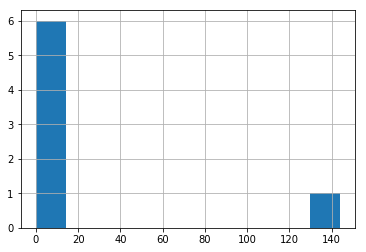

========================= DBLAB0102 =========================
1.9098488796248045 1752.0 0.0
under 2 minutes delay count: 5695
under 5 minutes delay count: 49
under 30 minutes delay count: 3
under 60 minutes delay count: 0
under 120 minutes delay count: 2
under 180 minutes delay count: 0
under 360 minutes delay count: 4
under inf minutes delay count: 4
[5695, 5744, 5747, 5747, 5749, 5749, 5753, 5757] / normal status rate: 98.92305019975682 %


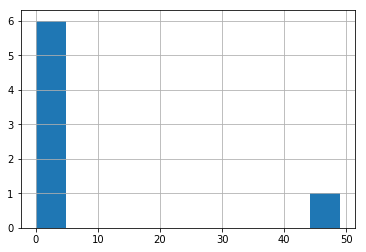

In [23]:
delay_range = [2, 5, 30, 60, 120, 180, 360, np.inf] #delay range in minutes.

for key, data in dataset.items():
    """
    Delays are formatted day, hour, min, and sec.
    Normalize delays to mintues
    """
    print(f"========================= {key} =========================")
    df = data['pos']
    df['delay_minute'] = df['delay'].map(lambda x: x.total_seconds() // 60 )
    print(df['delay_minute'].mean(), df['delay_minute'].max(), df['delay_minute'].min())    
    count_bucket = []
    for r in delay_range:
        count_bucket.append(len(df[df['delay_minute'] < r].index))
        if len(count_bucket) == 1:
            print(f"under {r} minutes delay count: {count_bucket[-1]}")
        else:
            print(f"under {r} minutes delay count: {count_bucket[-1] - count_bucket[-2]}")    
    print(f"{count_bucket} / normal status rate: {count_bucket[0] / count_bucket[-1] * 100} %")
    
    # show count hist except normal location data (< 2 mim)
    s = pd.Series(count_bucket)
    s = s.diff()        
    s = s.drop(s.index[0])    
    s.hist()
    plt.show()

<p>It seems that most of data were sent properly. (< 2 min) <br>
    Let's see the other big gaps in detail.
    </p>

In [24]:
def pick_gaps(df, r_min, r_max):
    """
    Make gaps which have duration of time between r_min and r_max from df's delay_minute
    """
    name = f'{r_min}_to_{r_max}'
    gaps = {
        'name': name,
        'min': r_min,
        'max': r_max,        
    }       
    # culling gaps
    gap_list = list(df[df['delay_minute'].between(r_min, r_max)].index)
    gaps['list'] = cull_gap_surroundings(df, gap_list)
    return gaps

In [25]:
def cull_gap_surroundings(df, gaps, around=2):           
    """return rows around the gap"""
    surroundings = []    
    for center in gaps:                
        rows = df[(center - around) : (center + around + 1)]
        '''
        TODO: Out of bound control
        slice doesn't raise Out of bound exception
        but it didn't not return when out of bound slice
        For now, works fine with our data
        '''
        surroundings.append({
            'gap': center,
            'rows': rows
        })   
    return surroundings        

In [26]:
for key, data in dataset.items():
    data['gaps'] = []
    for i, r in enumerate(reversed(delay_range[:-1])):  #We'll look up big gaps first
    #for i, r in enumerate(delay_range[1:]): #small gaps first
        pos = data['pos']        
        data['gaps'].append(pick_gaps(pos, r, delay_range[-(i+1)]))

<h3>5. Evaluation: Looking into the gaps</h3>
<p>We are looking into DBLAB0102 and DBLAB0103 first. They are always carried together, and turned on 24 hours except 1 day. So, they're the most controled test set.</p>

In [27]:
for i in range(len(delay_range) - 1):
    print(dataset['DBLAB0102']['gaps'][i]['name'], len(dataset['DBLAB0102']['gaps'][i]['list']), len(dataset['DBLAB0103']['gaps'][i]['list']))

360_to_inf 4 0
180_to_360 4 3
120_to_180 0 1
60_to_120 2 5
30_to_60 0 14
5_to_30 3 7
2_to_5 49 145


In [28]:
def show_gap_list(gaps, r_min):
    """show gap list from gaps with r_min range"""
    for gap in gaps:
        if gap['min'] == r_min:
            return gap        

In [29]:
gaps1 = dataset['DBLAB0102']['gaps']
gaps2 = dataset['DBLAB0103']['gaps']

In [30]:
# 360_to_inf 4 0
show_gap_list(gaps1, 360)

{'name': '360_to_inf',
 'min': 360,
 'max': inf,
 'list': [{'gap': 71,
   'rows':          name      id              servertime          devicetime   latitude  \
   69  DBLAB0102  294576 2019-01-20 23:22:18.916 2019-01-20 23:21:48  37.415326   
   70  DBLAB0102  294577 2019-01-20 23:22:57.473 2019-01-20 23:22:57  37.415328   
   71  DBLAB0102  295095 2019-01-21 08:26:04.552 2019-01-21 08:21:07  37.416503   
   72  DBLAB0102  295096 2019-01-21 08:26:04.708 2019-01-21 08:26:04  37.445378   
   73  DBLAB0102  295098 2019-01-21 08:27:37.985 2019-01-21 08:27:37  37.449017   
   
        longitude  battery_level    delay  delay_minute  
   69  126.879808           97.0 00:19:07          19.0  
   70  126.879844           97.0 00:01:09           1.0  
   71  126.884238           97.0 08:58:10         538.0  
   72  126.895622           97.0 00:04:57           4.0  
   73  126.895454           92.0 00:01:33           1.0  },
  {'gap': 1738,
   'rows':            name      id              serve

<h5>Very long Gaps (over 3 hours) DBLAB0102</h5>
<p>
71: Reported pause. It is not a bug.<br>
1739: iPhone alerted the app consume too much battery. It seems to block the client process <br>
    I noticed and confirmed at 01-24. ("입력 허가" in Korean) (I didn't unlock the test phone. I Just charged and carried it) <br>
3774: First day out from home (by car). Server received the data lately, but server was normal. (DBLAB0103 was sending its data). It seems that the device stopped sending the location, woke up from sleep mode then sending it again.<br>
4217: Same as above.
    </p>

In [31]:
#180_to_360 4 3

show_gap_list(gaps1, 180)

{'name': '180_to_360',
 'min': 180,
 'max': 360,
 'list': [{'gap': 357,
   'rows':           name      id              servertime          devicetime   latitude  \
   355  DBLAB0102  295754 2019-01-21 14:55:10.085 2019-01-21 14:55:09  37.555125   
   356  DBLAB0102  295756 2019-01-21 14:56:11.084 2019-01-21 14:56:10  37.555125   
   357  DBLAB0102  295946 2019-01-21 18:11:50.026 2019-01-21 18:11:43  37.555152   
   358  DBLAB0102  295948 2019-01-21 18:12:45.090 2019-01-21 18:12:44  37.555191   
   359  DBLAB0102  295950 2019-01-21 18:14:38.851 2019-01-21 18:13:45  37.555550   
   
         longitude  battery_level    delay  delay_minute  
   355  127.050063            2.0 00:01:01           1.0  
   356  127.050063            1.0 00:01:01           1.0  
   357  127.050041          100.0 03:15:33         195.0  
   358  127.050067          100.0 00:01:01           1.0  
   359  127.049522          100.0 00:01:01           1.0  },
  {'gap': 791,
   'rows':           name      id        

<h5>Long gaps ( > 180 min): DBLAB0102 (iPhone 6)</h5>
<p>
357: Turned off. Low battery.<br>
791: First day out from home (on foot). Awaken from sleep mode like DBLAB0102 3774.<br>
2771: Same as 791.
    </p>

In [32]:
show_gap_list(gaps2, 180)

{'name': '180_to_360',
 'min': 180,
 'max': 360,
 'list': [{'gap': 4513,
   'rows':            name      id              servertime          devicetime  \
   4511  DBLAB0103  309933 2019-01-24 16:46:43.438 2019-01-24 13:31:04   
   4512  DBLAB0103  309935 2019-01-24 16:46:59.156 2019-01-24 13:31:04   
   4513  DBLAB0103  309934 2019-01-24 16:46:43.526 2019-01-24 16:46:06   
   4514  DBLAB0103  309937 2019-01-24 16:47:34.542 2019-01-24 16:47:28   
   4515  DBLAB0103  309940 2019-01-24 16:48:37.972 2019-01-24 16:48:31   
   
          latitude   longitude  battery_level    delay  delay_minute  
   4511  37.555780  127.049504           94.0 00:01:05           1.0  
   4512  37.555780  127.049504           94.0 00:00:00           0.0  
   4513  37.555769  127.049499           94.0 03:15:02         195.0  
   4514  37.555765  127.049524           93.0 00:01:22           1.0  
   4515  37.555763  127.049526           93.0 00:01:03           1.0  },
  {'gap': 4840,
   'rows':            name 

<h5>Long Gaps (> 180 min): DBLAB0103 (Android)</h5>
<p>
4513: In workspace (indoor), unplugged. Same location. Network issue..? (AGPS)<br>
4840: Home (indoor). Same location (sleep). <br>
6168: Same as 4840. But, It seems to plugged that time. (battery level) <br>


<h5>Summmary on Long gaps (180_to_360 min)</h5>
<p>The experiment of DBLAB0102 and 0103 had begun Monday, 21st. Long gaps, it seems to be a kind of sleep mode activated. As I know, Traccar doesn't have sleep mode or idle mode. It might be OS' work.</p>
<p>Energy-saving mode of most Samsung galaxy smartphone's turns on three days after the last use of the app on foreground. I have recorded when I turned on the client at first, but I didn't when I check the client on foregoround -- that makes the energy-saving mode timer reset.</p>
<p>So far, I guess the long gaps (> 3 hours) usaually caused by sleep mode or energy saving procedure. It kept the location data (w/o sending) and send again when its state had been started to change (battery charging, or moving indoor to outdoor)
    </p>

In [33]:
#120_to_180 0 1
show_gap_list(gaps2, 120)

{'name': '120_to_180',
 'min': 120,
 'max': 180,
 'list': [{'gap': 4853,
   'rows':            name      id              servertime          devicetime  \
   4851  DBLAB0103  311824 2019-01-25 05:37:00.448 2019-01-25 05:36:59   
   4852  DBLAB0103  311826 2019-01-25 05:38:00.906 2019-01-25 05:37:59   
   4853  DBLAB0103  311941 2019-01-25 07:59:11.013 2019-01-25 07:59:09   
   4854  DBLAB0103  311942 2019-01-25 08:01:28.639 2019-01-25 08:00:54   
   4855  DBLAB0103  311943 2019-01-25 08:01:56.305 2019-01-25 08:01:55   
   
          latitude   longitude  battery_level    delay  delay_minute  
   4851  37.415687  126.879580           86.0 00:01:01           1.0  
   4852  37.415687  126.879580           86.0 00:01:00           1.0  
   4853  37.415687  126.879580           84.0 02:21:10         141.0  
   4854  37.415664  126.879561           84.0 00:01:45           1.0  
   4855  37.415664  126.879561           84.0 00:01:01           1.0  }]}

4853: Morning commute. Same as long gaps.

In [34]:
#60_to_120 2 5
show_gap_list(gaps1, 60)

{'name': '60_to_120',
 'min': 60,
 'max': 120,
 'list': [{'gap': 119,
   'rows':           name      id              servertime          devicetime   latitude  \
   117  DBLAB0102  295198 2019-01-21 09:27:28.768 2019-01-21 09:27:28  37.555067   
   118  DBLAB0102  295269 2019-01-21 10:40:36.633 2019-01-21 09:27:28  37.555067   
   119  DBLAB0102  295270 2019-01-21 10:40:36.915 2019-01-21 10:40:35  37.555115   
   120  DBLAB0102  295272 2019-01-21 10:41:40.577 2019-01-21 10:41:40  37.555111   
   121  DBLAB0102  295274 2019-01-21 10:42:45.589 2019-01-21 10:42:45  37.555097   
   
         longitude  battery_level    delay  delay_minute  
   117  127.050128           37.0 00:01:01           1.0  
   118  127.050128           37.0 00:00:00           0.0  
   119  127.050077           86.0 01:13:07          73.0  
   120  127.050112           87.0 00:01:05           1.0  
   121  127.050112           87.0 00:01:05           1.0  },
  {'gap': 577,
   'rows':           name      id          

Low Battery... battery drain protection of iOS..?

In [35]:
show_gap_list(gaps2, 60)

{'name': '60_to_120',
 'min': 60,
 'max': 120,
 'list': [{'gap': 1993,
   'rows':            name      id              servertime          devicetime  \
   1991  DBLAB0103  297453 2019-01-22 11:52:45.791 2019-01-22 11:52:41   
   1992  DBLAB0103  297530 2019-01-22 13:31:37.311 2019-01-22 11:53:41   
   1993  DBLAB0103  297531 2019-01-22 13:31:37.359 2019-01-22 13:31:20   
   1994  DBLAB0103  297533 2019-01-22 13:32:47.753 2019-01-22 13:32:43   
   1995  DBLAB0103  297534 2019-01-22 13:33:47.833 2019-01-22 13:33:43   
   
          latitude   longitude  battery_level    delay  delay_minute  
   1991  37.555761  127.049516           94.0 00:01:00           1.0  
   1992  37.555761  127.049516           94.0 00:01:00           1.0  
   1993  37.555767  127.049529           94.0 01:37:39          97.0  
   1994  37.555768  127.049528           93.0 00:01:23           1.0  
   1995  37.555768  127.049528           93.0 00:01:00           1.0  },
  {'gap': 4496,
   'rows':            name   

Indoor, stable.

In [36]:
#30_to_60 0 14
show_gap_list(gaps2, 30)

{'name': '30_to_60',
 'min': 30,
 'max': 60,
 'list': [{'gap': 1209,
   'rows':            name      id              servertime          devicetime  \
   1207  DBLAB0103  296193 2019-01-21 20:29:09.519 2019-01-21 20:29:05   
   1208  DBLAB0103  296195 2019-01-21 20:30:10.417 2019-01-21 20:30:06   
   1209  DBLAB0103  296242 2019-01-21 21:17:30.382 2019-01-21 21:17:25   
   1210  DBLAB0103  296244 2019-01-21 21:18:29.856 2019-01-21 21:18:26   
   1211  DBLAB0103  296246 2019-01-21 21:19:31.596 2019-01-21 21:19:27   
   
          latitude  longitude  battery_level    delay  delay_minute  
   1207  37.415601  126.87955           94.0 00:01:01           1.0  
   1208  37.415601  126.87955           94.0 00:01:01           1.0  
   1209  37.415601  126.87955           94.0 00:47:19          47.0  
   1210  37.415601  126.87955           94.0 00:01:01           1.0  
   1211  37.415601  126.87955           94.0 00:01:01           1.0  },
  {'gap': 1985,
   'rows':            name      id   

<h5>Summmary on mid-range gaps (30_to_180 min)</h5>
<p>Like long gaps, most mid-range gaps was occurred on low battery or indoor idle state</p>

In [37]:
#5_to_30 3 7

show_gap_list(gaps1, 5)

{'name': '5_to_30',
 'min': 5,
 'max': 30,
 'list': [{'gap': 69,
   'rows':          name      id              servertime          devicetime   latitude  \
   67  DBLAB0102  294574 2019-01-20 23:01:41.189 2019-01-20 23:01:41  37.415283   
   68  DBLAB0102  294575 2019-01-20 23:02:41.201 2019-01-20 23:02:41  37.415282   
   69  DBLAB0102  294576 2019-01-20 23:22:18.916 2019-01-20 23:21:48  37.415326   
   70  DBLAB0102  294577 2019-01-20 23:22:57.473 2019-01-20 23:22:57  37.415328   
   71  DBLAB0102  295095 2019-01-21 08:26:04.552 2019-01-21 08:21:07  37.416503   
   
        longitude  battery_level    delay  delay_minute  
   67  126.879879           95.0 00:01:02           1.0  
   68  126.879879           95.0 00:01:00           1.0  
   69  126.879808           97.0 00:19:07          19.0  
   70  126.879844           97.0 00:01:09           1.0  
   71  126.884238           97.0 08:58:10         538.0  },
  {'gap': 1739,
   'rows':            name      id              servertime 

Except gap #69, other gaps were occurred when the tester were commuting, on train (KTX) with tunnel. But it passes ground railway too. We should pay attention to this more. I need to check how long the train takes passing the tunnel.

In [38]:
show_gap_list(gaps2, 5)

{'name': '5_to_30',
 'min': 5,
 'max': 30,
 'list': [{'gap': 1216,
   'rows':            name      id              servertime          devicetime  \
   1214  DBLAB0103  296252 2019-01-21 21:22:33.442 2019-01-21 21:22:29   
   1215  DBLAB0103  296254 2019-01-21 21:23:33.452 2019-01-21 21:23:29   
   1216  DBLAB0103  296265 2019-01-21 21:33:47.451 2019-01-21 21:33:43   
   1217  DBLAB0103  296267 2019-01-21 21:34:47.823 2019-01-21 21:34:44   
   1218  DBLAB0103  296269 2019-01-21 21:35:50.031 2019-01-21 21:35:46   
   
          latitude  longitude  battery_level    delay  delay_minute  
   1214  37.415601  126.87955           94.0 00:01:00           1.0  
   1215  37.415601  126.87955           94.0 00:01:00           1.0  
   1216  37.415601  126.87955           93.0 00:10:14          10.0  
   1217  37.415601  126.87955           93.0 00:01:01           1.0  
   1218  37.415601  126.87955           93.0 00:01:02           1.0  },
  {'gap': 2083,
   'rows':            name      id     

Same as mid-range or long gap.

<h5>Summmary on short gaps (5_to_30 min)</h5>
<p>The gaps from iPhone was just the device passed a tunnel. It may take too much time to calibrate the location when it leaves the shaded area. </p>
<p>On the other hand, the gaps of Android(Samsung Galaxy S5) were similiar to longer gaps.
    </p>

In [39]:
#2_to_5 49 145

show_gap_list(gaps1, 2)

{'name': '2_to_5',
 'min': 2,
 'max': 5,
 'list': [{'gap': 72,
   'rows':          name      id              servertime          devicetime   latitude  \
   70  DBLAB0102  294577 2019-01-20 23:22:57.473 2019-01-20 23:22:57  37.415328   
   71  DBLAB0102  295095 2019-01-21 08:26:04.552 2019-01-21 08:21:07  37.416503   
   72  DBLAB0102  295096 2019-01-21 08:26:04.708 2019-01-21 08:26:04  37.445378   
   73  DBLAB0102  295098 2019-01-21 08:27:37.985 2019-01-21 08:27:37  37.449017   
   74  DBLAB0102  295100 2019-01-21 08:28:40.908 2019-01-21 08:28:40  37.464923   
   
        longitude  battery_level    delay  delay_minute  
   70  126.879844           97.0 00:01:09           1.0  
   71  126.884238           97.0 08:58:10         538.0  
   72  126.895622           97.0 00:04:57           4.0  
   73  126.895454           92.0 00:01:33           1.0  
   74  126.890106           90.0 00:01:03           1.0  },
  {'gap': 92,
   'rows':          name      id              servertime       

All the gaps were occurred during the commute, in subway.<br>
I need to look into what happens when the device is underground. And the locations quite wrong... it's serious. I'll have to take a closer later.

In [40]:
show_gap_list(gaps2, 2)

{'name': '2_to_5',
 'min': 2,
 'max': 5,
 'list': [{'gap': 2,
   'rows':         name      id              servertime          devicetime   latitude  \
   0  DBLAB0103  294579 2019-01-20 23:35:32.833 2019-01-20 23:35:29  37.415608   
   1  DBLAB0103  294580 2019-01-20 23:36:34.299 2019-01-20 23:36:30  37.415617   
   2  DBLAB0103  294581 2019-01-20 23:38:39.863 2019-01-20 23:38:36  37.415609   
   3  DBLAB0103  294582 2019-01-20 23:39:41.877 2019-01-20 23:39:38  37.415609   
   4  DBLAB0103  294583 2019-01-20 23:41:42.042 2019-01-20 23:41:38  37.415608   
   
       longitude  battery_level    delay  delay_minute  
   0  126.879547           92.0 00:00:40           0.0  
   1  126.879540           92.0 00:01:01           1.0  
   2  126.879547           93.0 00:02:06           2.0  
   3  126.879546           93.0 00:01:02           1.0  
   4  126.879548           94.0 00:02:00           2.0  },
  {'gap': 4,
   'rows':         name      id              servertime          devicetime  

Most gaps are same as long gaps. It is many but can be ignored.<br>
Sometimes, there also occurred during commute, but its location is not wrong. It shows exact subway line the device passed. 

<h5>Summmary on very short gaps (< 5 min)</h5>
<p>iPhone's gaps are very, very serious. The locations are weird. It is need to be further investigations.</p>
<p>On the other hand, Android(Samsung Galaxy S5) has way more gaps than iPhone, but they are trivial.
    </p>

<h3>6. Conclusion</h3>
<p><a href="http://db.hanyang.ac.kr/doku.php?id=traccar-test-01">Report</a></p>

<p>We have not yet experienced how Traccar works. This work give us a slight insight when Traccar got a delay.</p>
<p>Through the two devices, carried by normal 20's person who commutes on foot, by subway and train, we can prepare more for our future experiment.</p>
<p>Most long gaps, more than 30 minutes, occurred by battery issues and device's sleep mode. Therefore, we should build a monitoring system to notice and alert our participants. It will tell their device's status, especially low battery. Other gaps from idle state of the device are trivial because the locations are not changed.</p>
<p>However, the participants have to be informed the process can be blocked by their phone's OS. Since the smartphones have a little battery capacity for their power consumption, they are harsh to an app that takes their resources. We also saw that the iPhone blocked the client three day after in this test. We cannot find how we prevent the power saving policy. There is no options and settings, but the alert from the system. If any tester misses the alert and press right button 'Yes' --means block the app-- unconsciously, we will lose his/her all location after that. Unfortunately, some participants are so old that they are not familiar with their smartphones.</p>
<p>
    Besides, we need to further assessment of Traccar for more precise experiment. Our testing devices (DBLAB0102, 03) are quite old and in band condition. The iPhone has severe battery drain, and the Samsung seems to have a lag to get GPS signal. So, low battery teased the iPhone, and a minutes lag sticked the Samsung. If our participant's device is pretty old, it will to be examined to suitable the experiment. 
</p>
<p>
   We are under planning another short test with various, brand-new devices in good condition.
</p>

<table>
    <caption> Types of causes of long gaps</caption>
    <tr>
        <th>
            #
        </th>
        <th>
            Case
        </th>
        <th>
            Description
        </th>
        <th>
            Considerations
        </th>
    </tr>
    <tr>
        <td>
            1
        </td>
        <td>
            Low battery - Critical
        </td>
        <td>
            The device was turned off because its low battery.
        </td>
        <td>
            <ul>
            <li>Alert users.
                </li>
                <li>Give them addtional battery</li>
                </ul>
        </td>
    </tr>
    <tr>
        <td>
            2
        </td>
        <td>
            Low battery - Low power mode
        </td>
        <td>
            The system of the device turned off Traccar client because its battery is too low.
        </td>
        <td>
            <ul>            
            <li>Alert users.</li>
            <li>Give them addtional battery.</li>
            <li>We should investigate when the device switches low power mode by OS or devices.
            </li>
            </ul>
        </td>
    </tr>
    <tr>
        <td>
            3
        </td>
        <td>
            Sleep mode - No movement
        </td>
        <td>
            The device has no movement so that the system or Traccar client doesn't send the location until it moves obviously.
        </td>
        <td>
            <ul>
                <li>We should investigate when the device switches low power mode by OS or devices.</li>
            </ul>
        </td>
    </tr>
    <tr>
        <td>
            4
        </td>
        <td>
            Traccar blocked by device's power management
        </td>
        <td>
            During our test, Traccar runs in the background and take resources steadily. Most modern OSs are suspicious this kind of process.
        </td>
        <td>
            <ul>
                <li>Unlist Traccr from power management app lists.</li>
                <li>We need to pre-test to check the prevention of the OS. At least three days.</li>
                <li>It is possible a tester doesn't understand how to handle the device's setting.</li>
            </ul>
        </td>
    </tr>
</table>

In [41]:
# day iteration test
'''
start_date, end_date = period['DBLAB0103']['start'], period['DBLAB0103']['end']
print(start_date, end_date)
days = []
for single_date in daterange(start_date, end_date):
    days.append(single_date.replace(hour=0, minute=0, second=0))
print(days)
'''

"\nstart_date, end_date = period['DBLAB0103']['start'], period['DBLAB0103']['end']\nprint(start_date, end_date)\ndays = []\nfor single_date in daterange(start_date, end_date):\n    days.append(single_date.replace(hour=0, minute=0, second=0))\nprint(days)\n"

In [42]:
# delay mean by days
'''
for user in users['name']:
    print(f"========================={user}=========================")
    for single_date in daterange(period[user]['start'], period[user]['end']):
        today = single_date.replace(hour=0, minute=0, second=0)
        tomorrow  = today + timedelta(days=1)
        print(f"DAY {today} - {tomorrow}")        
        
        df = pos[user]        
        pos_by_day = df[(df['devicetime'] >= today) & (df['devicetime'] < tomorrow)]
        print(pos_by_day.head(5))
        if pos_by_day.shape[0] == 0:
            continue
        
        print("Delays")        
        print("mean", pos_by_day['delay'].mean())   
        print("max", pos_by_day['delay'].max(), pos_by_day['delay'].idxmax(), pos_by_day.loc[[pos_by_day['delay'].idxmax()]])   
        print("min", pos_by_day['delay'].min())   
        print()
'''

'\nfor user in users[\'name\']:\n    print(f"========================={user}=========================")\n    for single_date in daterange(period[user][\'start\'], period[user][\'end\']):\n        today = single_date.replace(hour=0, minute=0, second=0)\n        tomorrow  = today + timedelta(days=1)\n        print(f"DAY {today} - {tomorrow}")        \n        \n        df = pos[user]        \n        pos_by_day = df[(df[\'devicetime\'] >= today) & (df[\'devicetime\'] < tomorrow)]\n        print(pos_by_day.head(5))\n        if pos_by_day.shape[0] == 0:\n            continue\n        \n        print("Delays")        \n        print("mean", pos_by_day[\'delay\'].mean())   \n        print("max", pos_by_day[\'delay\'].max(), pos_by_day[\'delay\'].idxmax(), pos_by_day.loc[[pos_by_day[\'delay\'].idxmax()]])   \n        print("min", pos_by_day[\'delay\'].min())   \n        print()\n'